# Initial Imports

In [211]:
import os
import shutil
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from collections import Counter
from PIL import Image
import tensorflow as tf
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
import hdbscan
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.preprocessing import StandardScaler
import random
from tensorflow.keras import layers, Model
from tensorflow.keras import backend as K
from numba import cuda
from sklearn.preprocessing import LabelEncoder
import tensorflow_hub as hub
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score, silhouette_score
from sklearn.metrics import confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import accuracy_score, classification_report

In [2]:
physical_devices = tf.config.list_physical_devices('GPU')

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [37]:
# K.clear_session()
cuda.select_device(0) 
cuda.close()

# Data exploration

## Path Setup

In [60]:
data_directory = "data/disasters_dataset"
model_saves_directory = "model-saves"
original_directory = os.path.join(data_directory, "original")
processed_directory = os.path.join(data_directory, "processed")
train_directory = os.path.join(processed_directory, 'train')
test_directory = os.path.join(processed_directory, 'test')
valid_directory = os.path.join(processed_directory, 'valid')
pretrained_models_directory = os.path.join(model_saves_directory, 'models_pretrained')

In [4]:
os.makedirs(train_directory, exist_ok=True)
os.makedirs(valid_directory, exist_ok=True)
os.makedirs(test_directory, exist_ok=True)

## Disaster statistics and visualization

In [5]:
classes = [folder for folder in os.listdir(original_directory) if os.path.isdir(os.path.join(original_directory, folder))]

print("Classes found:", classes)

Classes found: ['drought', 'earthquake', 'human_damage', 'infrastructure', 'land_slide', 'non_damage_buildings_street', 'non_damage_human', 'non_damage_sea', 'non_damage_wildlife_forest', 'urban_fire', 'water_disaster', 'wild_fire']


In [6]:
def count_images_in_folder(folder_path):
    return len([f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])

data = []

for class_name in classes:
    class_path = os.path.join(original_directory, class_name)
    image_count = count_images_in_folder(class_path)
    data.append({'Class': class_name, 'Image Count': image_count})

class_image_statistic = pd.DataFrame(data)
class_image_statistic

Class  Image Count
0                       drought          201
1                    earthquake          174
2                  human_damage          240
3                infrastructure          557
4                    land_slide          456
5   non_damage_buildings_street          448
6              non_damage_human          120
7                non_damage_sea          569
8    non_damage_wildlife_forest          670
9                    urban_fire          419
10               water_disaster          507
11                    wild_fire          514

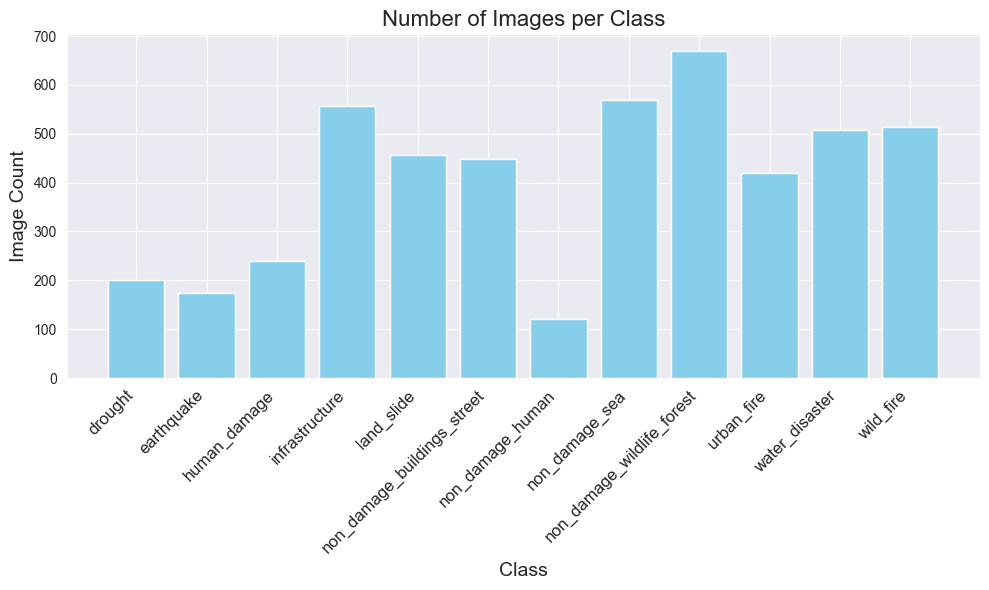

In [7]:
plt.figure(figsize=(10, 6))
plt.bar(class_image_statistic['Class'], class_image_statistic['Image Count'], color='skyblue')

plt.title('Number of Images per Class', fontsize=16)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Image Count', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.tight_layout()

plt.show()

## Explore dimensions of images

In [8]:
def get_image_sizes(directory):
    widths, heights = [], []
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                try:
                    with Image.open(img_path) as img:
                        width, height = img.size
                        widths.append(width)
                        heights.append(height)
                except Exception as e:
                    print(f"Error reading {img_path}: {e}")
    return widths, heights

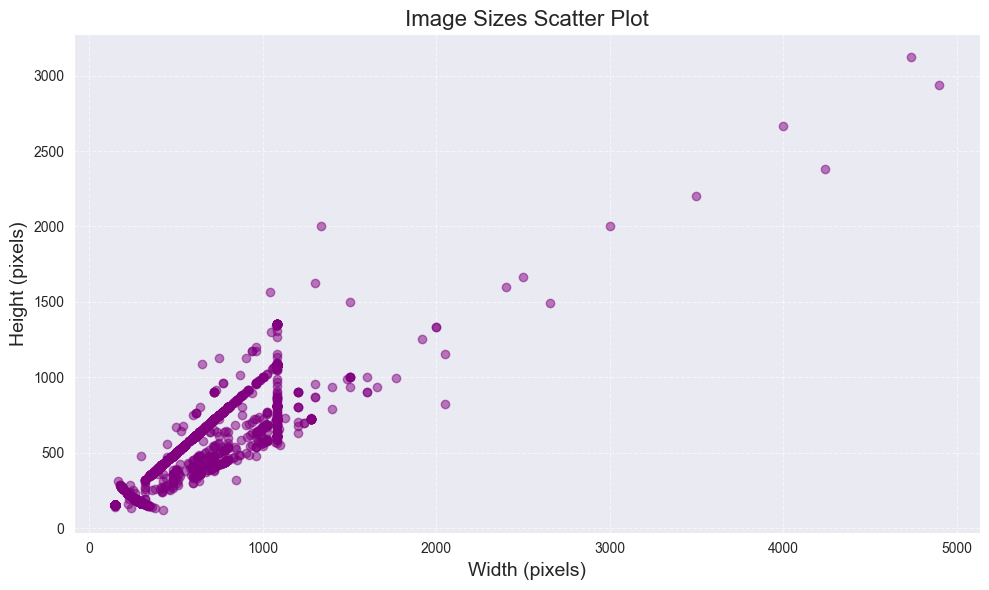

In [9]:
widths, heights = get_image_sizes(original_directory)

plt.figure(figsize=(10, 6))
plt.scatter(widths, heights, alpha=0.5, color='purple')
plt.title('Image Sizes Scatter Plot', fontsize=16)
plt.xlabel('Width (pixels)', fontsize=14)
plt.ylabel('Height (pixels)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

plt.show()

In [10]:
# INPUT_SIZE = (int(np.mean(widths)), int(np.mean(heights)))
# INPUT_SHAPE = (int(np.mean(widths)), int(np.mean(heights)), 3)
INPUT_SIZE = (200, 200)
INPUT_SHAPE = (200, 200, 3)
print(f"Input shape should be: {INPUT_SHAPE}")

Input shape should be: (200, 200, 3)


## Visualize images

In [11]:
def visualize_images_from_each_class(directory, classes, image_size=(150, 150)):
    num_classes = len(classes)
    fig, axes = plt.subplots(1, num_classes, figsize=(30, 10))
    
    for idx, cls in enumerate(classes):
        class_path = os.path.join(directory, cls)
        image_name = os.listdir(class_path)[0]  
        image_path = os.path.join(class_path, image_name)
        
        img = Image.open(image_path).convert('RGB')
        img_resized = img.resize(image_size)
        
        axes[idx].imshow(img_resized)
        axes[idx].set_title(cls)
        axes[idx].axis('off') 
    plt.tight_layout()
    plt.show()

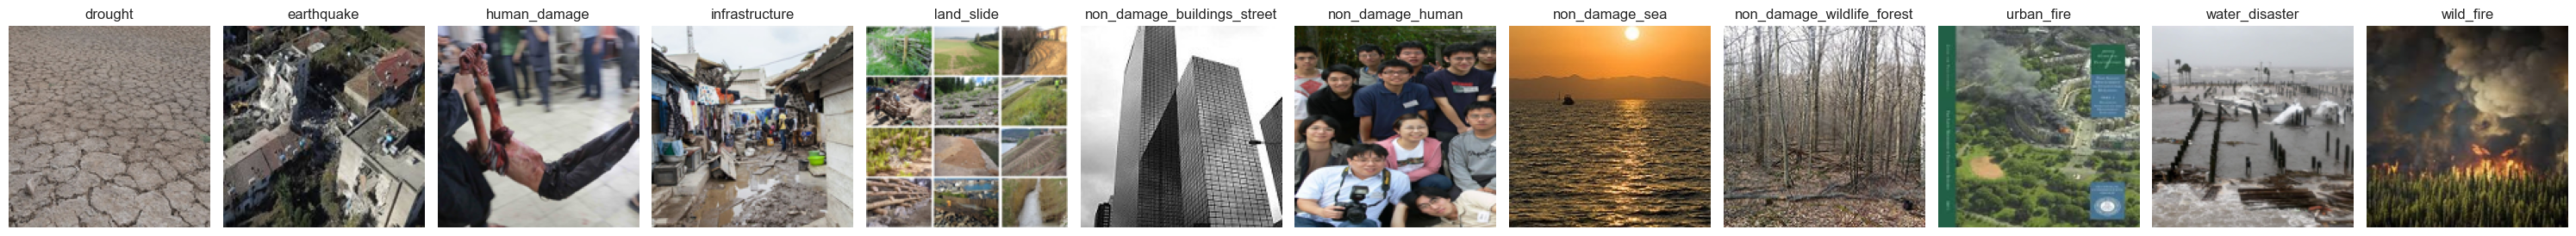

In [12]:
visualize_images_from_each_class(original_directory, classes)

# Split data for training, validation and testing

In [13]:
CLASSES_TO_KEEP = ["drought", "earthquake", "land_slide", "urban_fire", "water_disaster", "human_damage", "infrastructure"]
COMMON_IMAGE_COUNT = class_image_statistic[class_image_statistic['Class'].isin(CLASSES_TO_KEEP)]['Image Count'].min()
SPLIT_RATIOS = {'train': 0.7, 'valid': 0.2, 'test': 0.1}
COMMON_IMAGE_COUNT

174

In [14]:
def preprocess_and_split_data(original_directory, processed_directory, classes_to_keep, input_size, split_ratios, common_image_count):
    for cls in classes_to_keep:
        class_path = os.path.join(original_directory, cls)
        if not os.path.exists(class_path):
            print(f"Class {cls} does not exist in the dataset.")
            continue

        images = [img for img in os.listdir(class_path) if img.endswith(('.jpg', '.png'))]
        random.shuffle(images)
        selected_images = images[:common_image_count]

        train, temp = train_test_split(selected_images, test_size=1 - split_ratios['train'], random_state=42)
        valid, test = train_test_split(temp, test_size=split_ratios['test'] / (split_ratios['valid'] + split_ratios['test']), random_state=42)

        splits = {'train': train, 'valid': valid, 'test': test}

        for split_name, split_images in splits.items():
            split_dir = os.path.join(processed_directory, split_name, cls)
            os.makedirs(split_dir, exist_ok=True)

            for img_name in split_images:
                img_path = os.path.join(class_path, img_name)
                try:
                    img = Image.open(img_path).convert('RGB')  
                    img_resized = img.resize(input_size)
                    save_path = os.path.join(split_dir, img_name)
                    img_resized.save(save_path)
                except Exception as e:
                    print(f"Error processing image {img_name}: {e}")

In [ ]:
preprocess_and_split_data(original_directory, processed_directory, CLASSES_TO_KEEP, INPUT_SIZE, SPLIT_RATIOS, COMMON_IMAGE_COUNT)

## Split statistics

In [15]:
def plot_split_statistics(train_directory_param, valid_directory_param, test_directory_param, classes_param):
    def count_images_by_class(directory):
        class_counts = {}
        for cls in classes:
            class_path = os.path.join(directory, cls)
            if os.path.exists(class_path):
                class_counts[cls] = len(os.listdir(class_path))
            else:
                class_counts[cls] = 0
        return class_counts

    train_counts = count_images_by_class(train_directory_param)
    valid_counts = count_images_by_class(valid_directory_param)
    test_counts = count_images_by_class(test_directory_param)

    split_stats = pd.DataFrame({
        'Train': train_counts,
        'Valid': valid_counts,
        'Test': test_counts
    }).T  
    split_stats = split_stats[classes_param] 

    split_stats.plot(kind='bar', figsize=(12, 6), width=0.8)
    plt.title('Number of Images per Class in Preprocess Splits', fontsize=14)
    plt.xlabel('Split', fontsize=12)
    plt.ylabel('Number of Images', fontsize=12)
    plt.xticks(rotation=0)
    plt.legend(title='Classes', loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

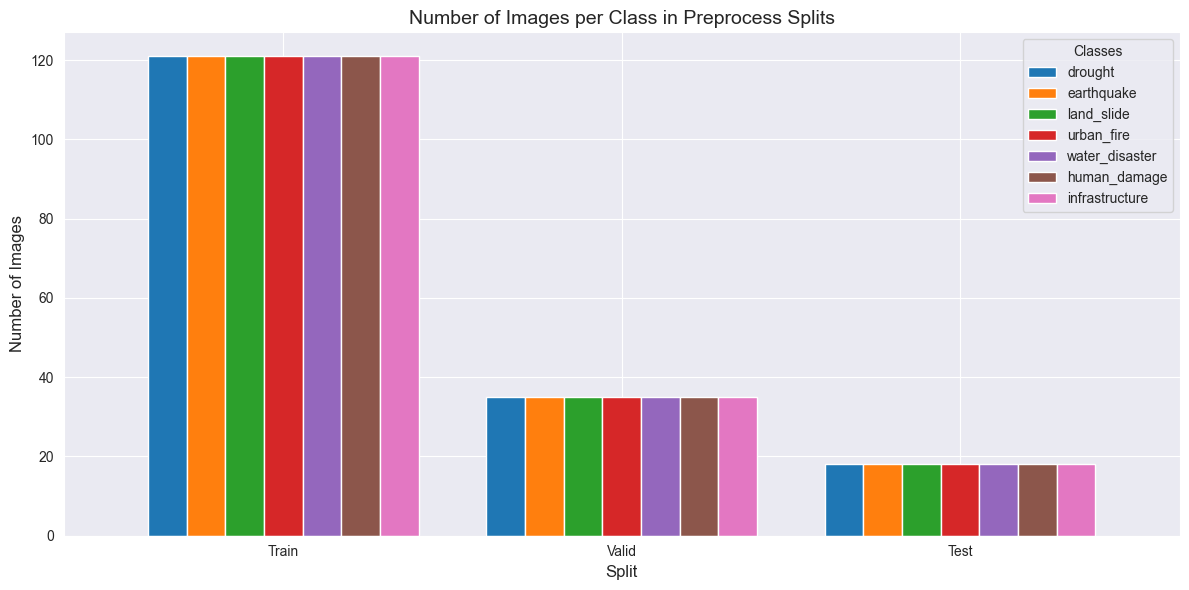

In [16]:
plot_split_statistics(train_directory, valid_directory, test_directory, CLASSES_TO_KEEP)

# Setup the data for unsupervised scenario

## Load and preprocess data (training and testing)

In [165]:
label_encoder = LabelEncoder()

In [166]:
training_directories = [train_directory, valid_directory]
training_images = []
training_labels = []
training_paths = []

for directory in training_directories:
    for class_folder in CLASSES_TO_KEEP:
        folder_path = os.path.join(directory, class_folder)
        for image_file in os.listdir(folder_path):
            image_path = os.path.join(folder_path, image_file)
            try:
                img = load_img(image_path, target_size=INPUT_SIZE)
                img_array = img_to_array(img)  
                img_array = img_to_array(img) / 255.0
                training_images.append(img_array)
                training_labels.append(class_folder)
                training_paths.append(image_path)
            except Exception as e:
                print(f"Error loading image {image_path}: {e}")
             
training_images_labels = np.array(training_labels)      
training_images_labels_encoded = label_encoder.fit_transform(training_images_labels)
                
training_images = np.array(training_images)

In [167]:
testing_images = []
testing_labels = []
testing_paths = []

for class_folder in CLASSES_TO_KEEP:
    folder_path = os.path.join(test_directory, class_folder)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        try:
            img = load_img(image_path, target_size=INPUT_SIZE)
            img_array = img_to_array(img)  
            testing_images.append(img_array)
            testing_labels.append(class_folder)
            testing_paths.append(image_path)
        except Exception as e:
            print(f"Error loading image {image_path}: {e}")

testing_images_labels = np.array(testing_labels)      
testing_images_labels_encoded = label_encoder.fit_transform(testing_images_labels)

testing_images = np.array(testing_images)

## Obtain embeddings / features

### Custom method (NN + autoencoder)

In [28]:
input_layer = layers.Input(shape=INPUT_SHAPE)
x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_layer)
x = layers.MaxPooling2D((2, 2))(x)  
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x)

x = layers.Flatten()(x)
bottleneck = layers.Dense(256, activation='relu')(x) 

x = layers.Dense(50 * 50 * 64, activation='relu')(bottleneck)
x = layers.Reshape((50, 50, 64))(x)  
x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  
x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
x = layers.UpSampling2D((2, 2))(x)  
output_layer = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x) 

autoencoder = Model(input_layer, output_layer)
encoder = Model(input_layer, bottleneck)  

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(training_images, training_images, epochs=10, batch_size=32)

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - loss: 0.0661
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 0.0571
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 65s 2s/step - loss: 0.0431
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 67s 2s/step - loss: 0.0375
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 63s 2s/step - loss: 0.0342
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0317
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0301
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - loss: 0.0287
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - loss: 0.0283
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 64s 2s/step - loss: 0.0270


In [215]:
encoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    40,960,256 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,979,648 (156.32 MB)

 Trainable params: 40,979,648 (156.32 MB)

 Non-trainable params: 0 (0.00 B)

In [214]:
autoencoder.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 200, 200, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 100, 100, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 100, 100, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 160000)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │    40,960,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 160000)         │    41,120,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 50, 50, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_2              │ (None, 50, 50, 64)     │        36,928 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 100, 100, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_3              │ (None, 100, 100, 32)   │        18,464 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_3 (UpSampling2D)  │ (None, 200, 200, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 200, 200, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 246,467,723 (940.20 MB)

 Trainable params: 82,155,907 (313.40 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 164,311,816 (626.80 MB)

In [29]:
custom_cnn_training_embeddings = encoder.predict(training_images)
custom_cnn_testing_embeddings = encoder.predict(testing_images)

print(f"Shape of training embeddings: {custom_cnn_training_embeddings.shape}")
print(f"Shape of testing embeddings: {custom_cnn_testing_embeddings.shape}")

35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
Shape of training embeddings: (1092, 256)
Shape of testing embeddings: (126, 256)


### Dimensionality reduction using PCA

In [50]:
training_images_flattened = training_images.reshape(training_images.shape[0], -1)
testing_images_flattened = testing_images.reshape(testing_images.shape[0], -1)

pca = PCA(n_components=256) 
training_embeddings_pca = pca.fit_transform(training_images_flattened)
testing_embeddings_pca = pca.transform(testing_images_flattened)

print(f"Shape of training embeddings: {training_embeddings_pca.shape}")
print(f"Shape of testing embeddings: {testing_embeddings_pca.shape}")

Shape of training embeddings: (1092, 256)
Shape of testing embeddings: (126, 256)


### Pretrained encoder (trained using unsupervised methods)

In [61]:
simclr_model_path = os.path.join(pretrained_models_directory, 'simclr-6.keras')
simclr_model = tf.keras.models.load_model(simclr_model_path)
simclr_model.summary()

TypeError: Could not locate class 'simCLR_UNet'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': None, 'class_name': 'simCLR_UNet', 'config': {'trainable': True, 'dtype': 'float32'}, 'registered_name': 'simCLR_UNet', 'build_config': {'input_shape': [16, 256, 256, 2]}, 'compile_config': {'optimizer': 'rmsprop', 'loss': None, 'loss_weights': None, 'metrics': None, 'weighted_metrics': None, 'run_eagerly': False, 'steps_per_execution': 1, 'jit_compile': True}}

In [75]:
def get_resnet_simclr(hidden_1, hidden_2, hidden_3):
    base_model = tf.keras.applications.ResNet50(include_top=False, weights=None, input_shape=INPUT_SHAPE)
    base_model.trainable = True
    inputs = tf.keras.layers.Input(INPUT_SHAPE)
    h = base_model(inputs, training=True)
    h = tf.keras.layers.GlobalAveragePooling2D()(h)

    projection_1 = tf.keras.layers.Dense(hidden_1)(h)
    projection_1 = tf.keras.layers.Activation("relu")(projection_1)
    projection_2 = tf.keras.layers.Dense(hidden_2)(projection_1)
    projection_2 = tf.keras.layers.Activation("relu")(projection_2)
    projection_3 = tf.keras.layers.Dense(hidden_3)(projection_2)

    resnet_simclr = tf.keras.Model(inputs, projection_3)

    return resnet_simclr

resnet_simclr_model = get_resnet_simclr(512, 256, 128)

def preprocess_images(images):
    images_resized = np.array([img_to_array(load_img(image_path, target_size=INPUT_SIZE)) for image_path in images])
    images_resized = images_resized / 255.0 
    return images_resized

def extract_embeddings(model, images):
    images_preprocessed = preprocess_images(images)
    embeddings = model.predict(images_preprocessed)
    return embeddings

resnet_simclr_model_training_embeddings = extract_embeddings(resnet_simclr_model, training_paths)
resnet_simclr_model_testing_embeddings = extract_embeddings(resnet_simclr_model, testing_paths)

35/35 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step


In [216]:
resnet_simclr_model.summary()

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,801,024 (94.61 MB)

 Trainable params: 24,747,904 (94.41 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [76]:
print(f"Shape of training embeddings: {resnet_simclr_model_training_embeddings.shape}")
print(f"Shape of testing embeddings: {resnet_simclr_model_testing_embeddings.shape}")

Shape of training embeddings: (1092, 128)
Shape of testing embeddings: (126, 128)


# Unsupervised Methods

## HDBSCAN + embeddings from custom CNN encoder

### Utility for evaluation

In [94]:
def evaluate_hdbscan(min_cluster_size_params, min_samples_params, embeddings_params):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size_params, 
                                 min_samples=min_samples_params, 
                                 metric='euclidean')
    clusterer.fit(embeddings_params)
    
    cluster_labels = clusterer.labels_
    num_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
    
    if num_clusters > 1:  
        silhouette = silhouette_score(embeddings_params, cluster_labels)
    else:
        silhouette = -1 

    return num_clusters, silhouette

### Finding the best parameters and getting the best results

In [99]:
hdbscan_param_grid = {
    'min_cluster_size': [2, 3, 5, 10, 20, 50],
    'min_samples': [1, 2, 5, 10, 15]
}

results = []

for min_cluster_size in hdbscan_param_grid['min_cluster_size']:
    for min_samples in hdbscan_param_grid['min_samples']:
        num_clusters, silhouette = evaluate_hdbscan(min_cluster_size, min_samples, custom_cnn_training_embeddings)
        results.append((min_cluster_size, min_samples, num_clusters, silhouette))

hdbscan_cnn_embedding_method_training_dataframe = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'num_clusters', 'silhouette_score'])
hdbscan_cnn_embedding_method_training_dataframe

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

min_cluster_size  min_samples  num_clusters  silhouette_score
0                  2            1           167         -0.151726
1                  2            2             3          0.352781
2                  2            5             2          0.379070
3                  2           10             2          0.241934
4                  2           15             0         -1.000000
5                  3            1            60         -0.226616
6                  3            2             3          0.352781
7                  3            5             4          0.086769
8                  3           10             2          0.241934
9                  3           15             0         -1.000000
10                 5            1            10         -0.001172
11                 5            2             7         -0.003389
12                 5            5             3          0.229297
13                 5           10             0         -1.000000
14                 5           15             0         -1.000000
15                10            1             4          0.104485
16                10            2             3          0.251329
17                10            5             2         -0.183140
18                10           10             0         -1.000000
19                10           15             0         -1.000000
20                20            1             0         -1.000000
21                20            2             0         -1.000000
22                20            5             0         -1.000000
23                20           10             0         -1.000000
24                20           15             0         -1.000000
25                50            1             0         -1.000000
26                50            2             0         -1.000000
27                50            5             0         -1.000000
28                50           10             0         -1.000000
29                50           15             0         -1.000000

In [100]:
hdbscan_cnn_best_result = hdbscan_cnn_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"min_cluster_size: {hdbscan_cnn_best_result['min_cluster_size']}")
print(f"min_samples: {hdbscan_cnn_best_result['min_samples']}")
print(f"Number of clusters: {hdbscan_cnn_best_result['num_clusters']}")
print(f"Silhouette Score: {hdbscan_cnn_best_result['silhouette_score']}")


Best Clustering Result:
min_cluster_size: 2.0
min_samples: 5.0
Number of clusters: 2.0
Silhouette Score: 0.3790704607963562


### Visualize distribution of samples per clusters

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


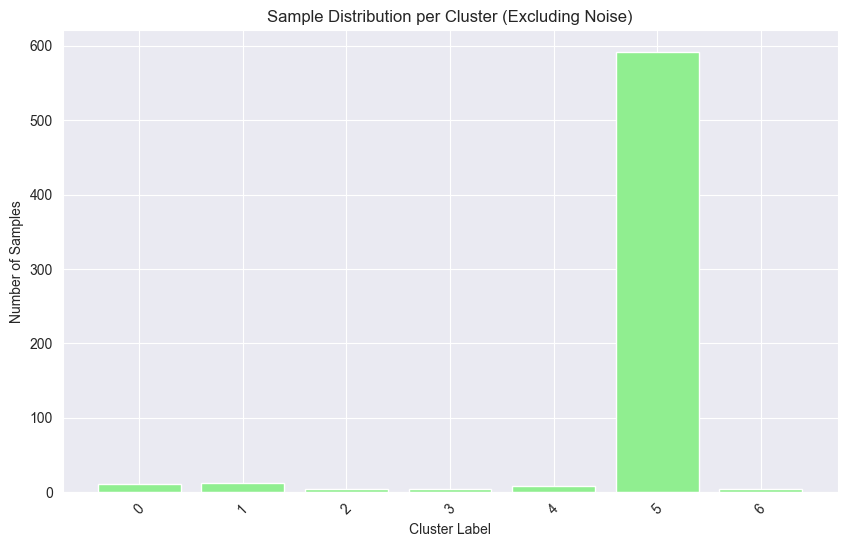

In [120]:
hdbscan_cnn_real_cluster_count_params = {
    'min_cluster_size': 5,
    'min_samples': 2
}

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2).fit_predict(custom_cnn_training_embeddings)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

non_noise_labels = unique_labels[unique_labels != -1]
non_noise_counts = counts[unique_labels != -1]

plt.figure(figsize=(10, 6))
plt.bar(non_noise_labels.astype(str), non_noise_counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

### Another way to visualize clusters (dimensonality reduction)

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


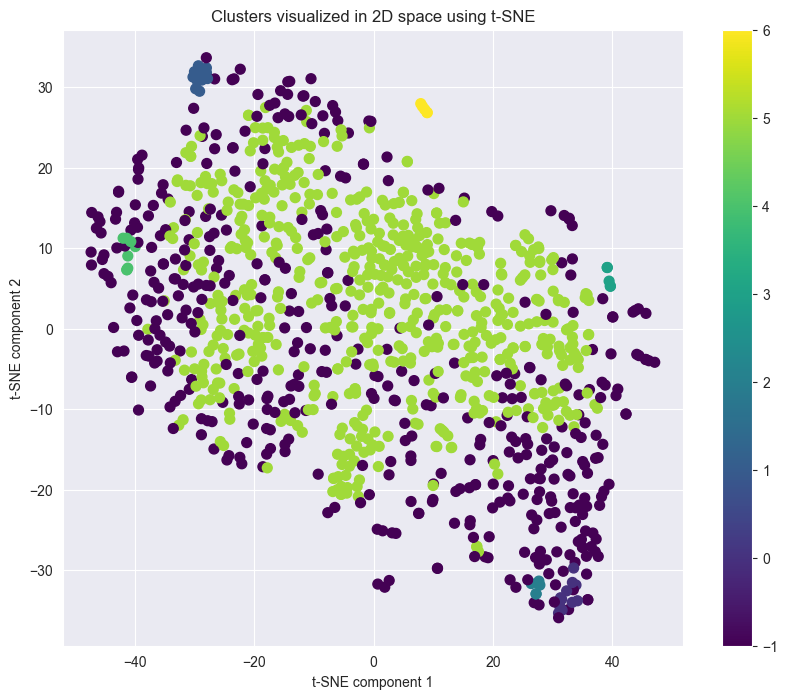

In [217]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(custom_cnn_training_embeddings)

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=2).fit_predict(custom_cnn_training_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## HDBSCAN + embeddings PCA

### Finding the best parameters and getting the best results

In [124]:
hdbscan_param_grid = {
    'min_cluster_size': [2, 3, 5, 10, 20, 50],
    'min_samples': [1, 2, 5, 10, 15]
}

results = []

for min_cluster_size in hdbscan_param_grid['min_cluster_size']:
    for min_samples in hdbscan_param_grid['min_samples']:
        num_clusters, silhouette = evaluate_hdbscan(min_cluster_size, min_samples, training_embeddings_pca)
        results.append((min_cluster_size, min_samples, num_clusters, silhouette))

hdbscan_pca_embedding_method_training_dataframe = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'num_clusters', 'silhouette_score'])
hdbscan_pca_embedding_method_training_dataframe

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

min_cluster_size  min_samples  num_clusters  silhouette_score
0                  2            1            84         -0.202292
1                  2            2            12         -0.205378
2                  2            5             3         -0.049006
3                  2           10             2         -0.257726
4                  2           15             2         -0.313853
5                  3            1            14         -0.162194
6                  3            2            10         -0.168647
7                  3            5             2          0.008428
8                  3           10             0         -1.000000
9                  3           15             2         -0.313853
10                 5            1             3         -0.007909
11                 5            2             3         -0.021699
12                 5            5             2         -0.177627
13                 5           10             0         -1.000000
14                 5           15             0         -1.000000
15                10            1             2         -0.136322
16                10            2             2         -0.282368
17                10            5             0         -1.000000
18                10           10             0         -1.000000
19                10           15             0         -1.000000
20                20            1             0         -1.000000
21                20            2             0         -1.000000
22                20            5             0         -1.000000
23                20           10             0         -1.000000
24                20           15             0         -1.000000
25                50            1             0         -1.000000
26                50            2             0         -1.000000
27                50            5             0         -1.000000
28                50           10             0         -1.000000
29                50           15             0         -1.000000

In [125]:
hdbscan_pca_best_result = hdbscan_pca_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"min_cluster_size: {hdbscan_pca_best_result['min_cluster_size']}")
print(f"min_samples: {hdbscan_pca_best_result['min_samples']}")
print(f"Number of clusters: {hdbscan_pca_best_result['num_clusters']}")
print(f"Silhouette Score: {hdbscan_pca_best_result['silhouette_score']}")


Best Clustering Result:
min_cluster_size: 3.0
min_samples: 5.0
Number of clusters: 2.0
Silhouette Score: 0.008427604101598263


### Visualize distribution of samples per clusters

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


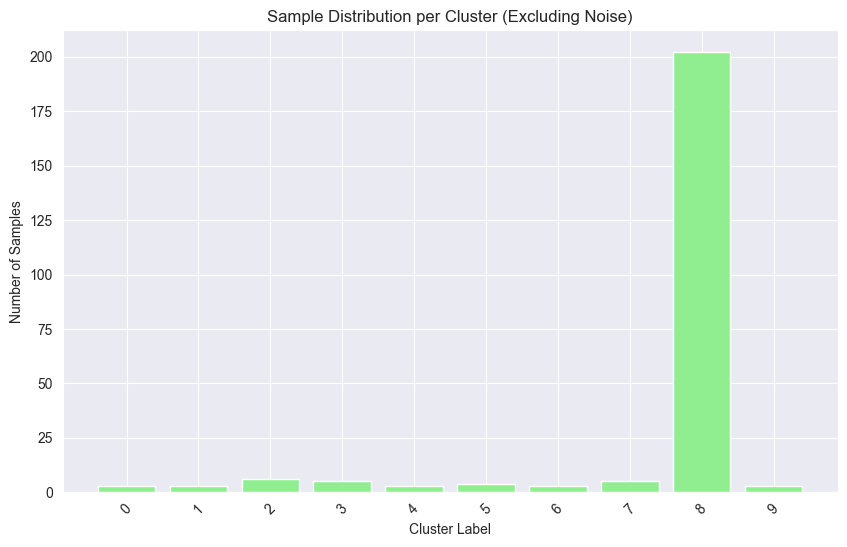

In [126]:
hdbscan_pca_closest_cluster_count_params = {
    'min_cluster_size': 3,
    'min_samples': 2
}

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2).fit_predict(training_embeddings_pca)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

non_noise_labels = unique_labels[unique_labels != -1]
non_noise_counts = counts[unique_labels != -1]

plt.figure(figsize=(10, 6))
plt.bar(non_noise_labels.astype(str), non_noise_counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

### Another way to visualize clusters (dimensonality reduction)

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


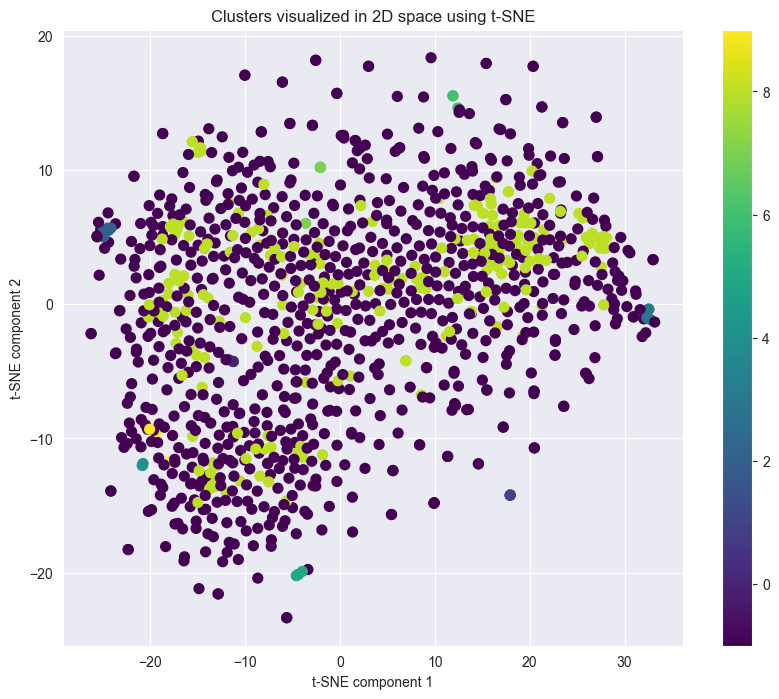

In [127]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(training_embeddings_pca)

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=3, min_samples=2).fit_predict(training_embeddings_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## HDBSCAN + Embeddings from pretrained

### Finding the best parameters and getting the best results

In [128]:
hdbscan_param_grid = {
    'min_cluster_size': [2, 3, 5, 10, 20, 50],
    'min_samples': [1, 2, 5, 10, 15]
}

results = []

for min_cluster_size in hdbscan_param_grid['min_cluster_size']:
    for min_samples in hdbscan_param_grid['min_samples']:
        num_clusters, silhouette = evaluate_hdbscan(min_cluster_size, min_samples, resnet_simclr_model_training_embeddings)
        results.append((min_cluster_size, min_samples, num_clusters, silhouette))

hdbscan_pretrained_embedding_method_training_dataframe = pd.DataFrame(results, columns=['min_cluster_size', 'min_samples', 'num_clusters', 'silhouette_score'])
hdbscan_pretrained_embedding_method_training_dataframe

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

min_cluster_size  min_samples  num_clusters  silhouette_score
0                  2            1           215         -0.233279
1                  2            2             9         -0.170292
2                  2            5             3          0.358358
3                  2           10             2          0.542956
4                  2           15             2         -0.093026
5                  3            1            10         -0.196055
6                  3            2            12         -0.165292
7                  3            5             2          0.394660
8                  3           10             2          0.542956
9                  3           15             2         -0.093026
10                 5            1             8         -0.153076
11                 5            2             2          0.329925
12                 5            5             2          0.394660
13                 5           10             2          0.182045
14                 5           15             4         -0.535298
15                10            1             5          0.092913
16                10            2             2          0.329925
17                10            5             2          0.181124
18                10           10             4         -0.512172
19                10           15             4         -0.535298
20                20            1             2          0.208774
21                20            2             2         -0.012245
22                20            5             2         -0.294648
23                20           10             3         -0.454184
24                20           15             2         -0.401458
25                50            1             3         -0.246171
26                50            2             3         -0.310043
27                50            5             2         -0.294648
28                50           10             0         -1.000000
29                50           15             0         -1.000000

In [129]:
hdbscan_pretrained_best_result = hdbscan_pretrained_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"min_cluster_size: {hdbscan_pretrained_best_result['min_cluster_size']}")
print(f"min_samples: {hdbscan_pretrained_best_result['min_samples']}")
print(f"Number of clusters: {hdbscan_pretrained_best_result['num_clusters']}")
print(f"Silhouette Score: {hdbscan_pretrained_best_result['silhouette_score']}")


Best Clustering Result:
min_cluster_size: 2.0
min_samples: 10.0
Number of clusters: 2.0
Silhouette Score: 0.5429563522338867


### Visualize distribution of samples per clusters

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


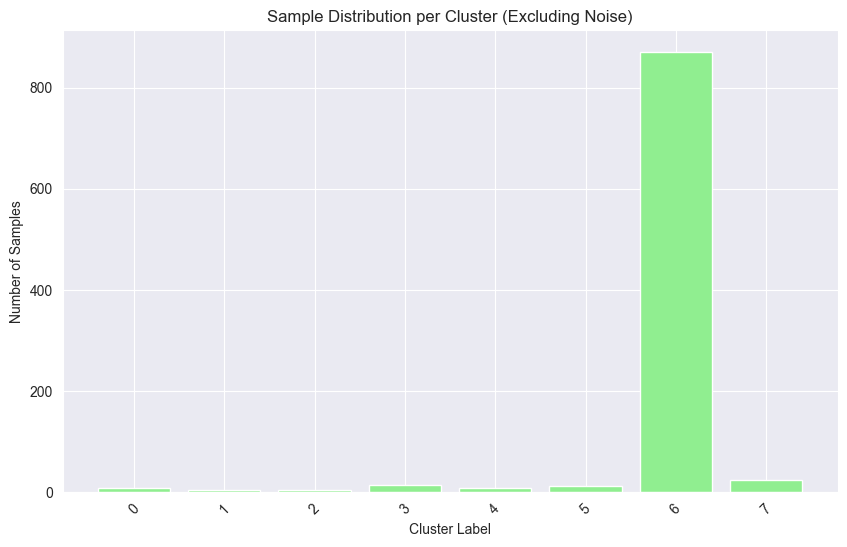

In [130]:
hdbscan_pca_closest_cluster_count_params = {
    'min_cluster_size': 5,
    'min_samples': 1
}

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1).fit_predict(resnet_simclr_model_training_embeddings)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

non_noise_labels = unique_labels[unique_labels != -1]
non_noise_counts = counts[unique_labels != -1]

plt.figure(figsize=(10, 6))
plt.bar(non_noise_labels.astype(str), non_noise_counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

### Another way to visualize clusters (dimensonality reduction)

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


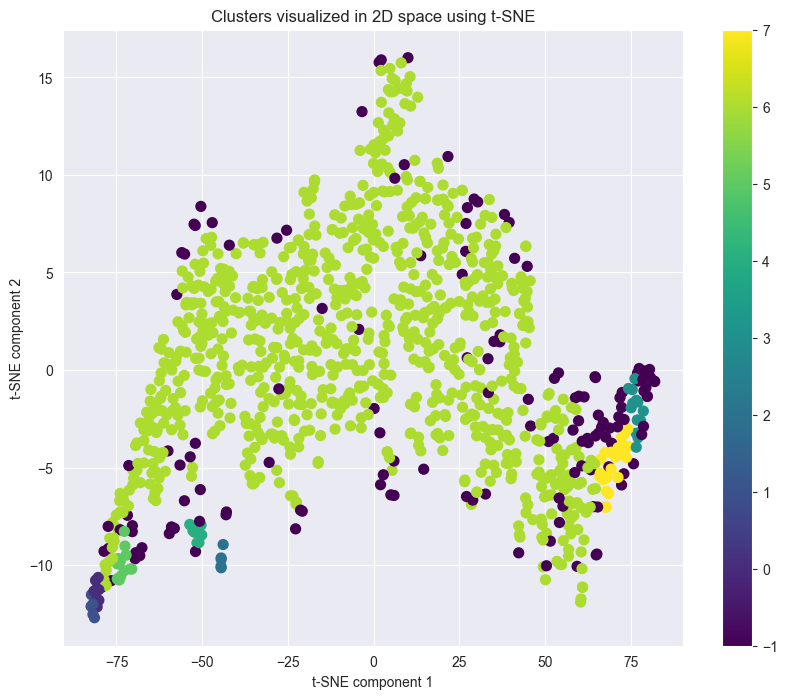

In [131]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(resnet_simclr_model_training_embeddings)

cluster_labels = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=1).fit_predict(resnet_simclr_model_training_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## Aglomerative Clustering + embeddings from custom CNN encoder

### Utility for evaluation

In [132]:
def evaluate_agglomerative(n_clusters_params, linkage_params, embeddings_params):
    clusterer = AgglomerativeClustering(n_clusters=n_clusters_params, 
                                        linkage=linkage_params, 
                                        metric='euclidean')
    cluster_labels = clusterer.fit_predict(embeddings_params)
    num_clusters = len(set(cluster_labels))  
    
    if num_clusters > 1:  
        silhouette = silhouette_score(embeddings_params, cluster_labels)
    else:
        silhouette = -1 
    
    return silhouette

### Finding the best parameters and getting the best results

In [133]:
agglomerative_param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],  
    'linkage': ['ward', 'complete', 'average', 'single'] 
}

results = []

for n_clusters in agglomerative_param_grid['n_clusters']:
    for linkage in agglomerative_param_grid['linkage']:
        silhouette = evaluate_agglomerative(n_clusters, linkage, custom_cnn_training_embeddings)
        results.append((n_clusters, linkage, silhouette))
        
agglomerative_cnn_embedding_method_training_dataframe = pd.DataFrame(results, columns=['n_clusters', 'linkage', 'silhouette_score'])
agglomerative_cnn_embedding_method_training_dataframe

n_clusters   linkage  silhouette_score
0            2      ward          0.445130
1            2  complete          0.398927
2            2   average          0.487646
3            2    single          0.543987
4            3      ward          0.114462
5            3  complete          0.314151
6            3   average          0.438467
7            3    single          0.420213
8            4      ward          0.075185
9            4  complete          0.242206
10           4   average          0.387332
11           4    single          0.414931
12           5      ward          0.081469
13           5  complete          0.239745
14           5   average          0.383726
15           5    single          0.245532
16           6      ward          0.034811
17           6  complete          0.181563
18           6   average          0.378847
19           6    single          0.219143
20           7      ward          0.035123
21           7  complete          0.181128
22           7   average          0.379417
23           7    single          0.214735
24           8      ward          0.037355
25           8  complete          0.173835
26           8   average          0.318878
27           8    single          0.215228

In [134]:
agglomerative_cnn_best_result = agglomerative_cnn_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"n_clusters: {agglomerative_cnn_best_result['n_clusters']}")
print(f"linkage: {agglomerative_cnn_best_result['linkage']}")
print(f"Silhouette Score: {agglomerative_cnn_best_result['silhouette_score']}")


Best Clustering Result:
n_clusters: 2
linkage: single
Silhouette Score: 0.5439867973327637


### Visualize distribution of samples per clusters and dataframe results

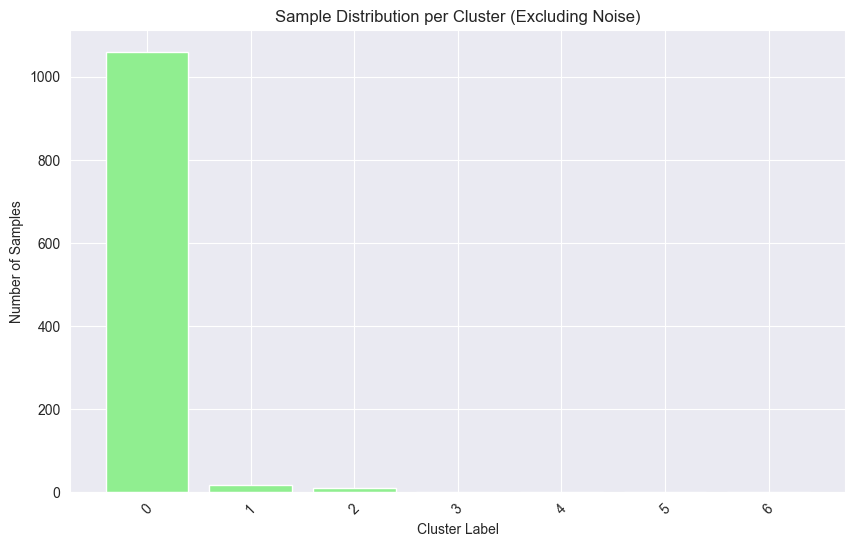

In [135]:
agglomerative_cnn_real_cluster_count_params = {
    'n_clusters': 7,
    'linkage': 'average'
}

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(custom_cnn_training_embeddings)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels.astype(str), counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

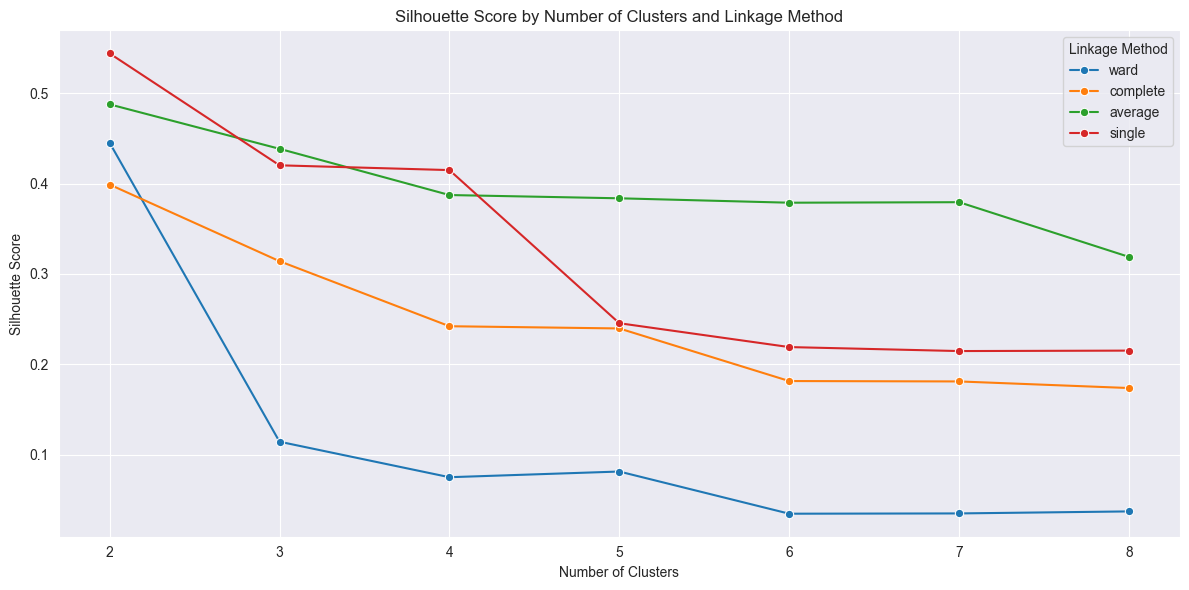

In [136]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=agglomerative_cnn_embedding_method_training_dataframe, x="n_clusters", y="silhouette_score", hue="linkage", marker="o")
plt.title("Silhouette Score by Number of Clusters and Linkage Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Linkage Method")
plt.grid(True)
plt.tight_layout()
plt.show()

### Another way to visualize clusters (dimensonality reduction)

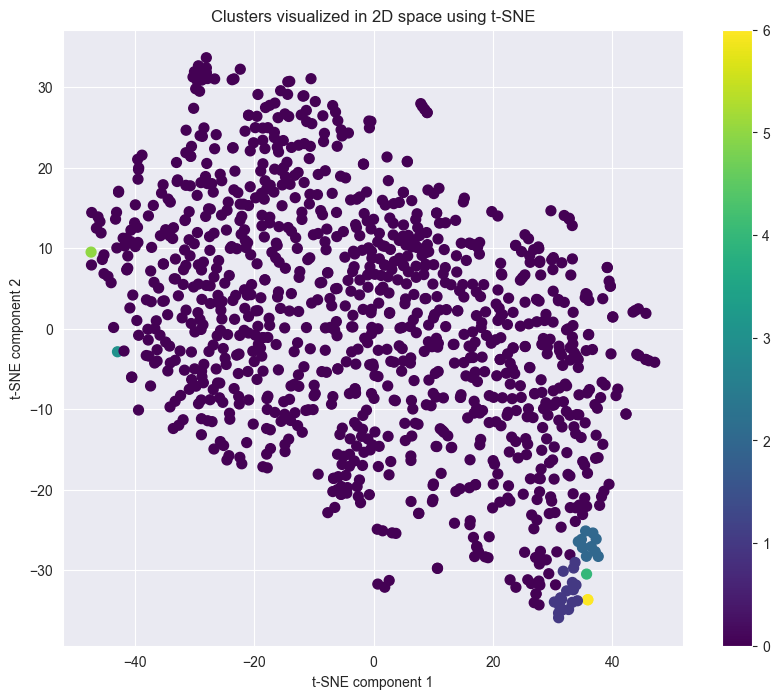

In [137]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(custom_cnn_training_embeddings)

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(custom_cnn_training_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## Aglomerative Clustering + embeddings PCA

### Finding the best parameters and getting the best results

In [138]:
agglomerative_param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],  
    'linkage': ['ward', 'complete', 'average', 'single'] 
}

results = []

for n_clusters in agglomerative_param_grid['n_clusters']:
    for linkage in agglomerative_param_grid['linkage']:
        silhouette = evaluate_agglomerative(n_clusters, linkage, training_embeddings_pca)
        results.append((n_clusters, linkage, silhouette))
        
agglomerative_pca_embedding_method_training_dataframe = pd.DataFrame(results, columns=['n_clusters', 'linkage', 'silhouette_score'])
agglomerative_pca_embedding_method_training_dataframe

n_clusters   linkage  silhouette_score
0            2      ward          0.122149
1            2  complete          0.152702
2            2   average          0.407961
3            2    single          0.407961
4            3      ward          0.076829
5            3  complete          0.086548
6            3   average          0.240239
7            3    single          0.234170
8            4      ward          0.071643
9            4  complete          0.082953
10           4   average          0.208102
11           4    single          0.208102
12           5      ward          0.048874
13           5  complete          0.081695
14           5   average          0.182923
15           5    single          0.160060
16           6      ward          0.041565
17           6  complete          0.037508
18           6   average          0.156412
19           6    single          0.126629
20           7      ward          0.042120
21           7  complete          0.033800
22           7   average          0.152544
23           7    single          0.111150
24           8      ward          0.038206
25           8  complete          0.029322
26           8   average          0.136430
27           8    single          0.093893

In [139]:
agglomerative_pca_best_result = agglomerative_pca_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"n_clusters: {agglomerative_pca_best_result['n_clusters']}")
print(f"linkage: {agglomerative_pca_best_result['linkage']}")
print(f"Silhouette Score: {agglomerative_pca_best_result['silhouette_score']}")


Best Clustering Result:
n_clusters: 2
linkage: average
Silhouette Score: 0.40796056389808655


### Visualize distribution of samples per clusters and dataframe results

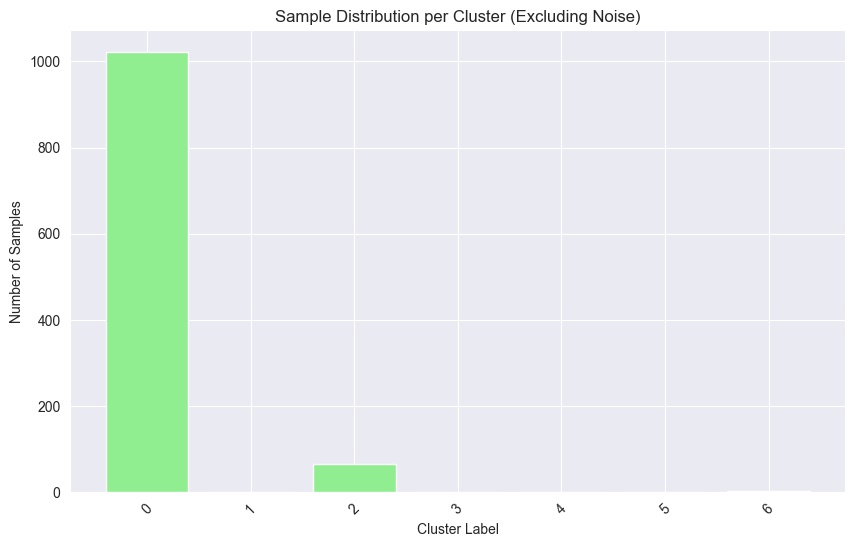

In [140]:
agglomerative_cnn_real_cluster_count_params = {
    'n_clusters': 7,
    'linkage': 'average'
}

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(training_embeddings_pca)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels.astype(str), counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

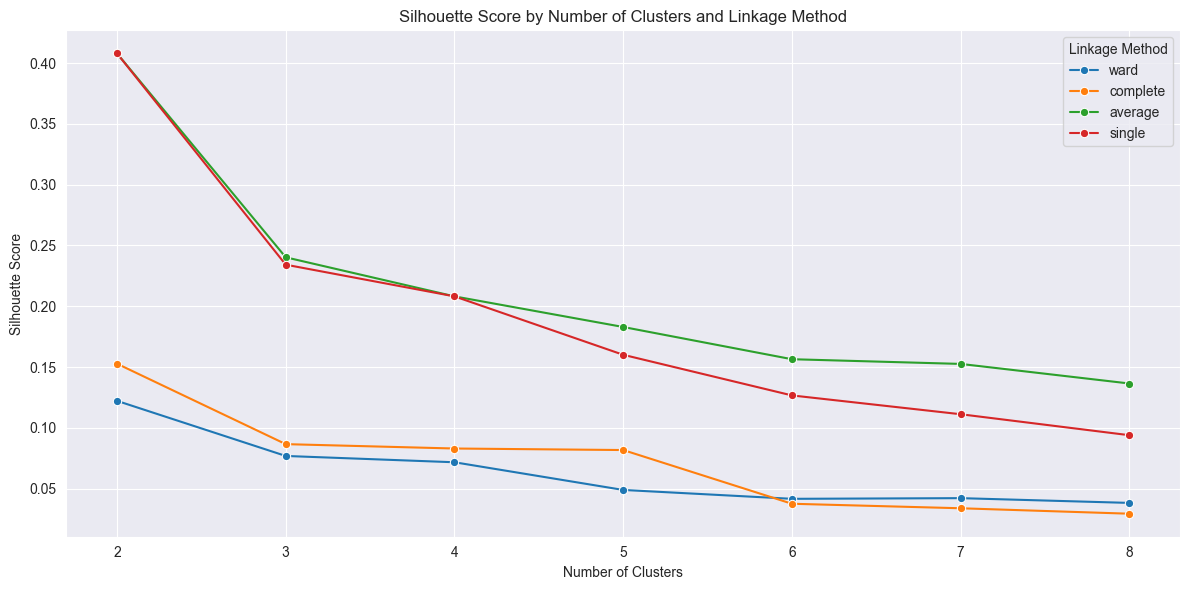

In [141]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=agglomerative_pca_embedding_method_training_dataframe, x="n_clusters", y="silhouette_score", hue="linkage", marker="o")
plt.title("Silhouette Score by Number of Clusters and Linkage Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Linkage Method")
plt.grid(True)
plt.tight_layout()
plt.show()

### Another way to visualize clusters (dimensonality reduction)

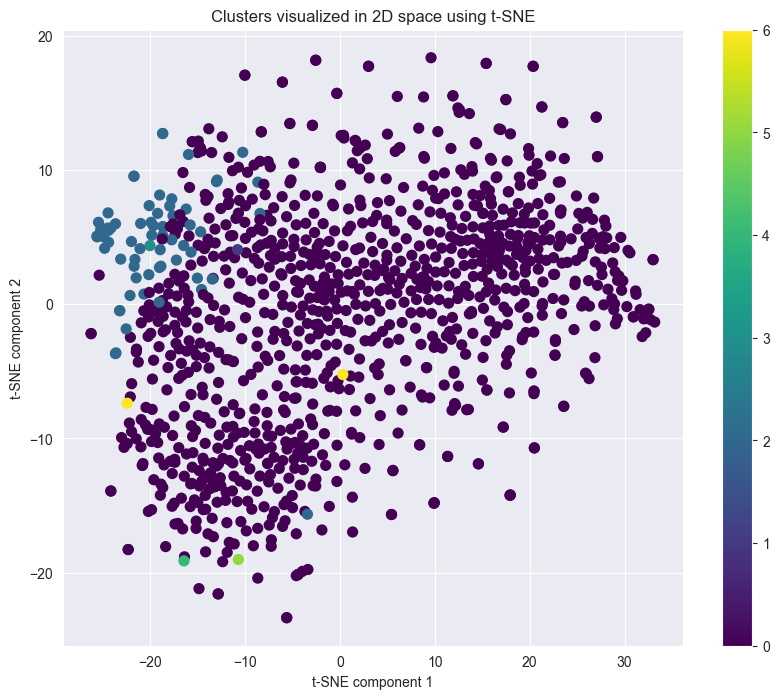

In [142]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(training_embeddings_pca)

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(training_embeddings_pca)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## Aglomerative Clustering + Embeddings from pretrained

### Finding the best parameters and getting the best results

In [220]:
agglomerative_param_grid = {
    'n_clusters': [2, 3, 4, 5, 6, 7, 8],  
    'linkage': ['ward', 'complete', 'average', 'single'] 
}

results = []

for n_clusters in agglomerative_param_grid['n_clusters']:
    for linkage in agglomerative_param_grid['linkage']:
        silhouette = evaluate_agglomerative(n_clusters, linkage, resnet_simclr_model_training_embeddings)
        results.append((n_clusters, linkage, silhouette))
        
agglomerative_pretrained_embedding_method_training_dataframe = pd.DataFrame(results, columns=['n_clusters', 'linkage', 'silhouette_score'])
agglomerative_pretrained_embedding_method_training_dataframe

n_clusters   linkage  silhouette_score
0            2      ward          0.475853
1            2  complete          0.461140
2            2   average          0.710697
3            2    single          0.710697
4            3      ward          0.399522
5            3  complete          0.428266
6            3   average          0.475876
7            3    single          0.678708
8            4      ward          0.416904
9            4  complete          0.422541
10           4   average          0.412274
11           4    single         -0.173125
12           5      ward          0.370115
13           5  complete          0.376260
14           5   average          0.369686
15           5    single         -0.242656
16           6      ward          0.365556
17           6  complete          0.333174
18           6   average          0.314114
19           6    single         -0.376486
20           7      ward          0.311251
21           7  complete          0.378394
22           7   average          0.403244
23           7    single         -0.400466
24           8      ward          0.313746
25           8  complete          0.368111
26           8   average          0.401627
27           8    single         -0.404802

In [221]:
agglomerative_pretrained_best_result = agglomerative_pretrained_embedding_method_training_dataframe.sort_values(by='silhouette_score', ascending=False).iloc[0]

print("\nBest Clustering Result:")
print(f"n_clusters: {agglomerative_pretrained_best_result['n_clusters']}")
print(f"linkage: {agglomerative_pretrained_best_result['linkage']}")
print(f"Silhouette Score: {agglomerative_pretrained_best_result['silhouette_score']}")


Best Clustering Result:
n_clusters: 2
linkage: average
Silhouette Score: 0.7106966376304626


### Visualize distribution of samples per clusters and dataframe results

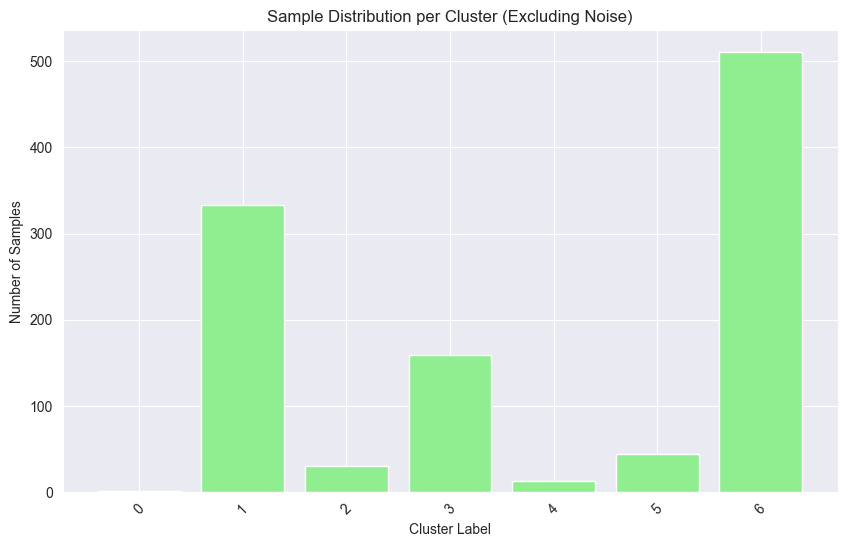

In [222]:
agglomerative_cnn_real_cluster_count_params = {
    'n_clusters': 7,
    'linkage': 'average'
}

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(resnet_simclr_model_training_embeddings)
unique_labels, counts = np.unique(cluster_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels.astype(str), counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Excluding Noise)')
plt.xticks(rotation=45)
plt.show()

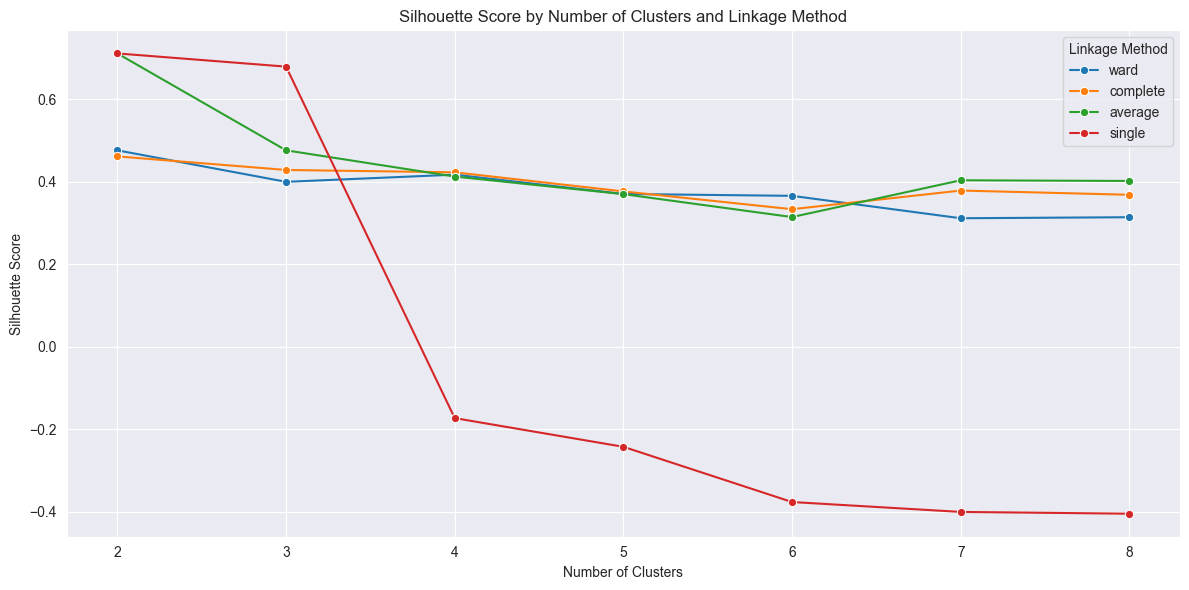

In [223]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=agglomerative_pretrained_embedding_method_training_dataframe, x="n_clusters", y="silhouette_score", hue="linkage", marker="o")
plt.title("Silhouette Score by Number of Clusters and Linkage Method")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.legend(title="Linkage Method")
plt.grid(True)
plt.tight_layout()
plt.show()

### Another way to visualize clusters (dimensonality reduction)

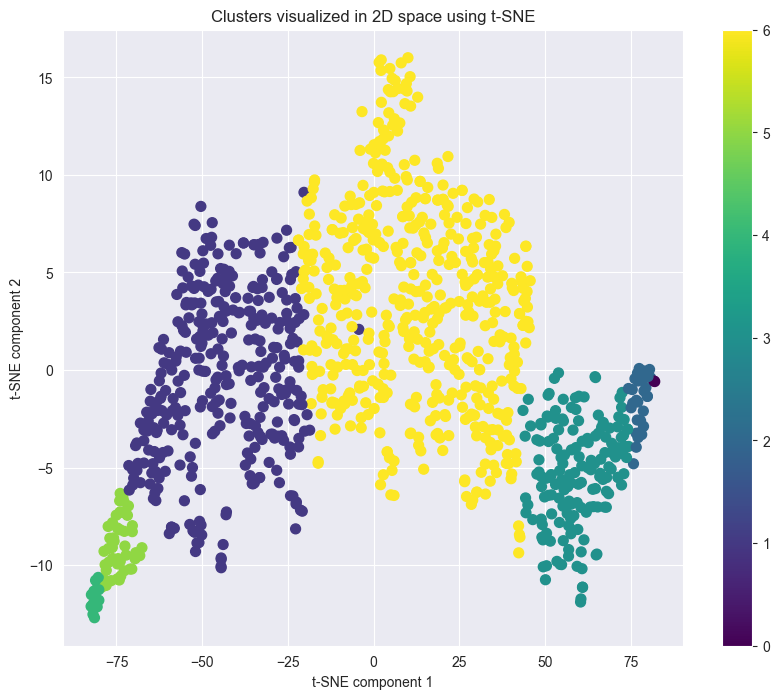

In [224]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(resnet_simclr_model_training_embeddings)

cluster_labels = AgglomerativeClustering(n_clusters=7, linkage='average', metric='euclidean').fit_predict(resnet_simclr_model_training_embeddings)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

## Random choice

### Utility for evaluation

In [195]:
def evaluate_random_clustering(num_clusters_params, embeddings_params):
    random_labels = np.random.randint(0, num_clusters_params, size=len(embeddings_params))
    
    if num_clusters_params > 1:
        silhouette = silhouette_score(embeddings_params, random_labels)
    else:
        silhouette = -1 
    
    return num_clusters_params, silhouette

### Finding the best parameters and getting the best results

In [196]:
cnn_random_cluster_params = range(2, 11)

results = []

for num_clusters in cnn_random_cluster_params:
    num_clusters, silhouette = evaluate_random_clustering(num_clusters, custom_cnn_training_embeddings)
    results.append((num_clusters, silhouette))
        
random_method_training_dataframe = pd.DataFrame(results, columns=['num_clusters', 'silhouette_score'])
random_method_training_dataframe

num_clusters  silhouette_score
0             2          0.000107
1             3         -0.011636
2             4         -0.012819
3             5         -0.030534
4             6         -0.015008
5             7         -0.023635
6             8         -0.023780
7             9         -0.038761
8            10         -0.034746

In [197]:
random_best_result = random_method_training_dataframe.sort_values(by='silhouette_score').iloc[0]

print("\nBest Clustering Result:")
print(f"num_clusters: {random_best_result['num_clusters']}")
print(f"Silhouette Score: {random_best_result['silhouette_score']}")


Best Clustering Result:
num_clusters: 9.0
Silhouette Score: -0.03876134008169174


### Visualize distribution of samples per clusters and dataframe results

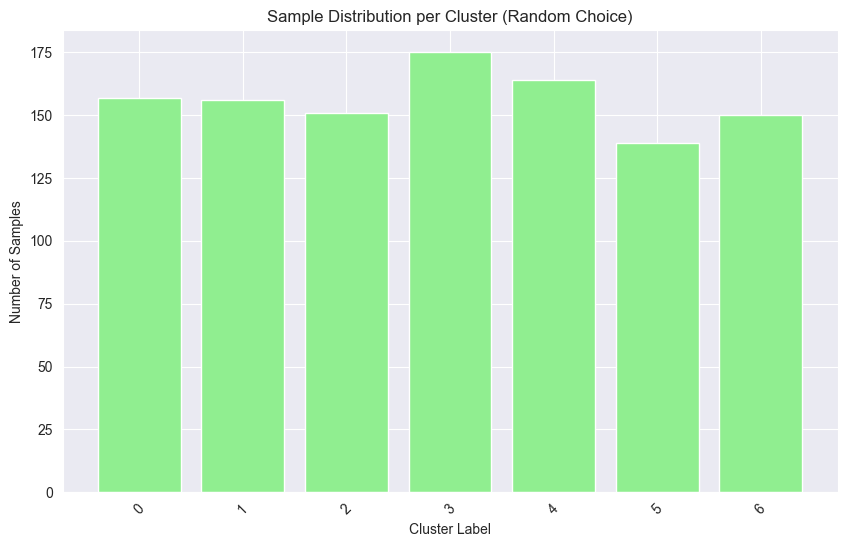

In [198]:
random_real_cluster_count_params = {
    'num_clusters': 7
}

random_labels = np.random.randint(0, 7, size=len(custom_cnn_training_embeddings))
unique_labels, counts = np.unique(random_labels, return_counts=True)

plt.figure(figsize=(10, 6))
plt.bar(unique_labels.astype(str), counts, color='lightgreen')
plt.xlabel('Cluster Label')
plt.ylabel('Number of Samples')
plt.title('Sample Distribution per Cluster (Random Choice)')
plt.xticks(rotation=45)
plt.show()

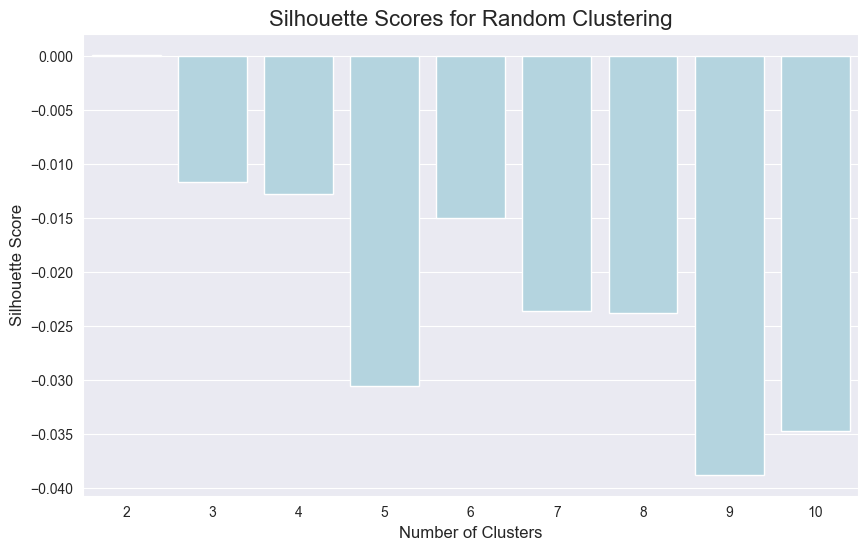

In [199]:
plt.figure(figsize=(10, 6))
sns.barplot(x="num_clusters", y="silhouette_score", data=random_method_training_dataframe, color='lightblue')

plt.title("Silhouette Scores for Random Clustering", fontsize=16)
plt.xlabel("Number of Clusters", fontsize=12)
plt.ylabel("Silhouette Score", fontsize=12)

plt.show()

### Another way to visualize clusters (dimensonality reduction)

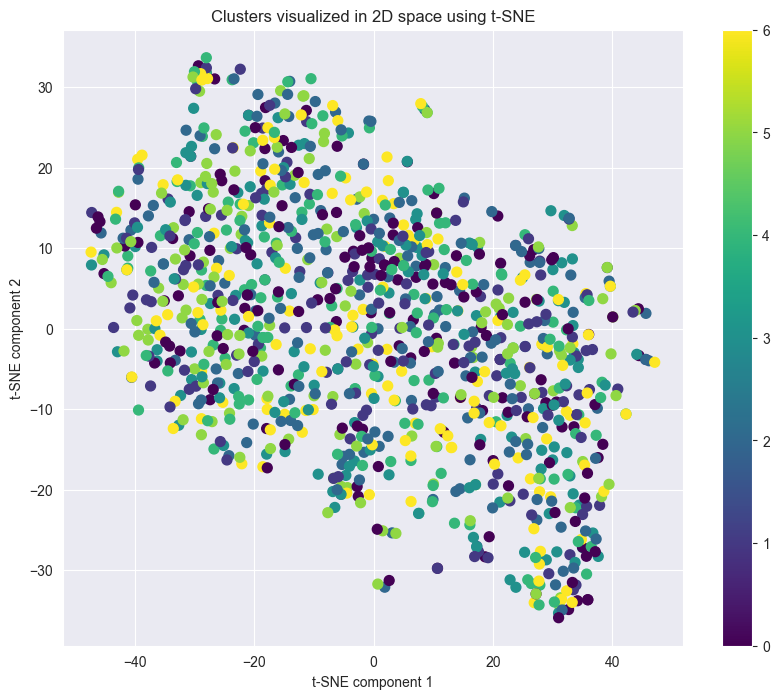

In [200]:
tsne_model = TSNE(n_components=2, random_state=42, metric='euclidean')
tsne_embeddings = tsne_model.fit_transform(custom_cnn_training_embeddings)

random_cnn_training_cluster_labels = np.random.randint(0, 7, size=len(custom_cnn_training_embeddings))

plt.figure(figsize=(10, 8))
scatter = plt.scatter(tsne_embeddings[:, 0], tsne_embeddings[:, 1], c=random_cnn_training_cluster_labels, cmap='viridis', s=50)
plt.colorbar(scatter)
plt.title("Clusters visualized in 2D space using t-SNE")
plt.xlabel("t-SNE component 1")
plt.ylabel("t-SNE component 2")
plt.show()

# Evaluating on testing data

## Utilities

In [204]:
testing_embeddings_methods = {
    "custom_cnn": custom_cnn_testing_embeddings,
    "pca": testing_embeddings_pca,
    "simclr": resnet_simclr_model_testing_embeddings
}

hdbscan_params = {
    "custom_cnn": {
        'min_cluster_size': 5,
        'min_samples': 2
    },
    "pca": {
        'min_cluster_size': 3,
        'min_samples': 2
    },
    "simclr": {
        'min_cluster_size': 5,
        'min_samples': 1
    }
}

agglomerative_params = {
    "custom_cnn": {
        'n_clusters': 7,
        'linkage': 'average'
    },
    "pca": {
        'n_clusters': 7,
        'linkage': 'average'
    },
    "simclr": {
        'n_clusters': 7,
        'linkage': 'average'
    }
}

In [205]:
def evaluate_clustering_on_testing(cluster_labels_params, embeddings_params, true_labels_params):
    ari = adjusted_rand_score(true_labels_params, cluster_labels_params)
    nmi = normalized_mutual_info_score(true_labels_params, cluster_labels_params)
    if len(set(cluster_labels_params)) > 1:
        silhouette = silhouette_score(embeddings_params, cluster_labels_params)
    else:
        silhouette = -1
    return ari, nmi, silhouette

## Evaluate HDBSCAN, Agglomerative Clustering & Random Choice on Testing dataset

In [206]:
final_testing_results = []

for embedding_name, embeddings in testing_embeddings_methods.items():
    hdbscan_clusterer = hdbscan.HDBSCAN(**hdbscan_params[embedding_name], metric='euclidean')
    hdbscan_cluster_labels = hdbscan_clusterer.fit_predict(embeddings)
    ari, nmi, silhouette = evaluate_clustering_on_testing(hdbscan_cluster_labels, embeddings, testing_images_labels_encoded)
    final_testing_results.append(["HDBSCAN", embedding_name, ari, nmi, silhouette])

    agglomerative_clusterer = AgglomerativeClustering(**agglomerative_params[embedding_name], metric='euclidean')
    agglomerative_cluster_labels = agglomerative_clusterer.fit_predict(embeddings)
    ari, nmi, silhouette = evaluate_clustering_on_testing(agglomerative_cluster_labels, embeddings, testing_images_labels_encoded)
    final_testing_results.append(["Agglomerative", embedding_name, ari, nmi, silhouette])

    random_labels = np.random.randint(0, len(CLASSES_TO_KEEP), size=len(embeddings))
    ari, nmi, silhouette = evaluate_clustering_on_testing(random_labels, embeddings, testing_images_labels_encoded)
    final_testing_results.append(["Random Choice", embedding_name, ari, nmi, silhouette])
    
final_testing_results

D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
D:\Programs\Anaconda\envs\testing_env\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finit

[['HDBSCAN',
  'custom_cnn',
  0.024269588547204755,
  0.12083878810679664,
  -0.1370636],
 ['Agglomerative',
  'custom_cnn',
  0.012007214011644092,
  0.14426384791834282,
  0.099822745],
 ['Random Choice',
  'custom_cnn',
  -0.010642338107334857,
  0.07163726976277454,
  -0.09523722],
 ['HDBSCAN', 'pca', 0.0064299037116094995, 0.08160857396743988, -0.21124439],
 ['Agglomerative', 'pca', 0.00960953545379533, 0.1471914831097752, 0.1047164],
 ['Random Choice',
  'pca',
  -0.0025476505000943572,
  0.07428637503500006,
  -0.05187608],
 ['HDBSCAN', 'simclr', 0.014126592121652855, 0.11058758710898231, 0.4135726],
 ['Agglomerative',
  'simclr',
  0.05479696741158258,
  0.19132664930425866,
  0.41584983],
 ['Random Choice',
  'simclr',
  -0.010661550933097919,
  0.060332395884310615,
  -0.14080815]]

## Displaying the final results

In [209]:
final_results_dataframe = pd.DataFrame(final_testing_results, columns=["Method", "Embedding", "ARI", "NMI", "Silhouette"])
final_results_dataframe

Method   Embedding       ARI       NMI  Silhouette
0        HDBSCAN  custom_cnn  0.024270  0.120839   -0.137064
1  Agglomerative  custom_cnn  0.012007  0.144264    0.099823
2  Random Choice  custom_cnn -0.010642  0.071637   -0.095237
3        HDBSCAN         pca  0.006430  0.081609   -0.211244
4  Agglomerative         pca  0.009610  0.147191    0.104716
5  Random Choice         pca -0.002548  0.074286   -0.051876
6        HDBSCAN      simclr  0.014127  0.110588    0.413573
7  Agglomerative      simclr  0.054797  0.191327    0.415850
8  Random Choice      simclr -0.010662  0.060332   -0.140808

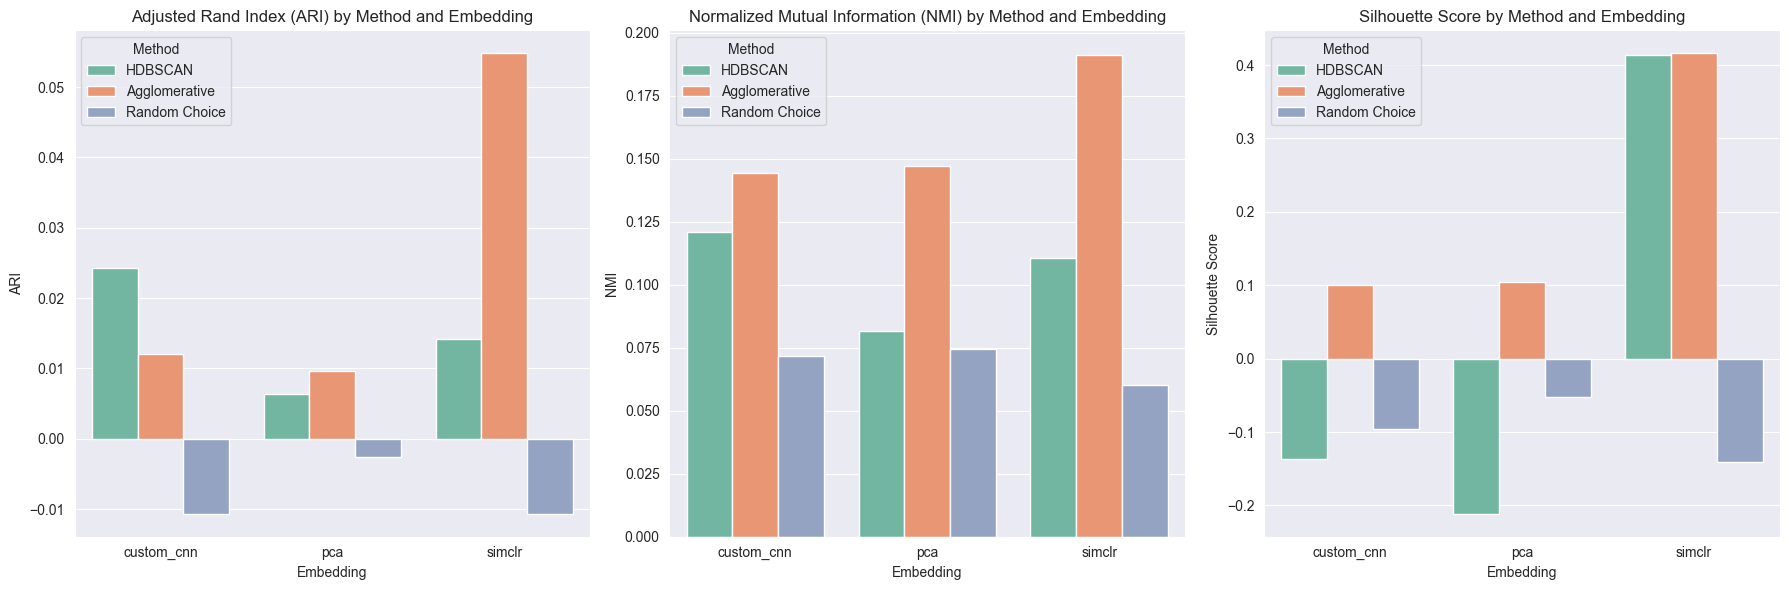

In [210]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.barplot(data=final_results_dataframe, x="Embedding", y="ARI", hue="Method", palette="Set2", ax=axes[0])
axes[0].set_title("Adjusted Rand Index (ARI) by Method and Embedding")
axes[0].set_ylabel("ARI")

sns.barplot(data=final_results_dataframe, x="Embedding", y="NMI", hue="Method", palette="Set2", ax=axes[1])
axes[1].set_title("Normalized Mutual Information (NMI) by Method and Embedding")
axes[1].set_ylabel("NMI")

sns.barplot(data=final_results_dataframe, x="Embedding", y="Silhouette", hue="Method", palette="Set2", ax=axes[2])
axes[2].set_title("Silhouette Score by Method and Embedding")
axes[2].set_ylabel("Silhouette Score")

plt.tight_layout()
plt.show()

# Attempting to get an interpretation based on labels and majority in the cluster

In [212]:
cluster_to_class_map = {}

for cluster in set(cluster_labels):
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
    cluster_true_labels = [training_images_labels_encoded[i] for i in cluster_indices]
    majority_class = Counter(cluster_true_labels).most_common(1)[0][0]
    cluster_to_class_map[cluster] = majority_class

print(cluster_to_class_map)

{0: 4, 1: 5, 2: 0, 3: 0, 4: 5, 5: 5, 6: 6}


C:\Users\Alex-PC\AppData\Local\Temp\ipykernel_4204\2044564410.py:27: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x='Cluster', y='Count', hue='Label', data=filtered_df, ci=None)


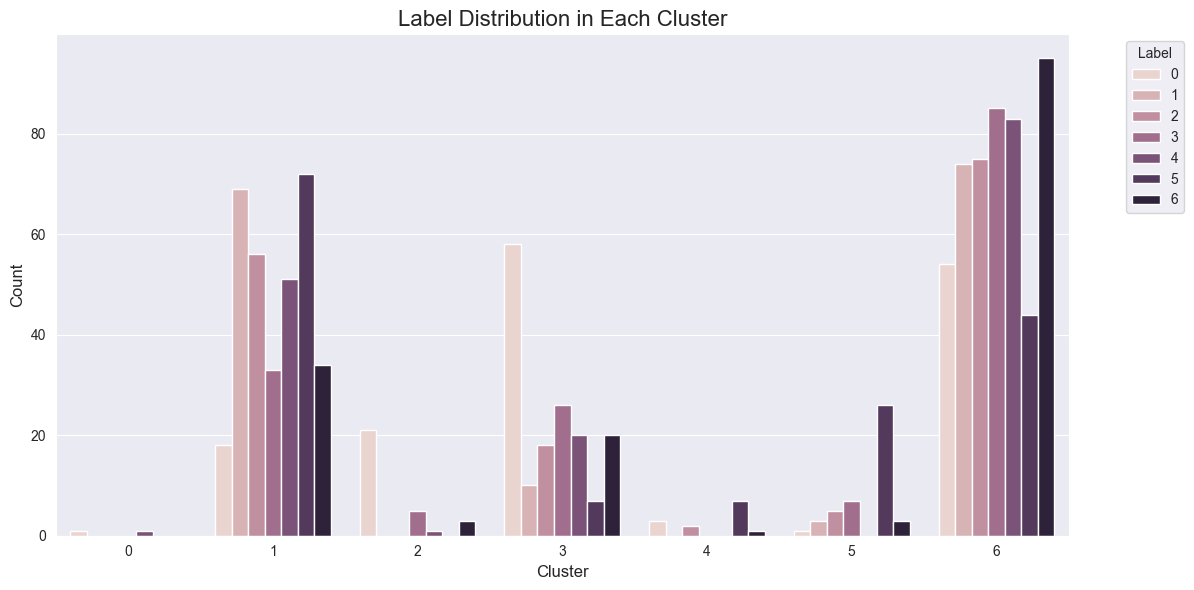

In [225]:
# Create a list to store cluster information
cluster_data = []

# Loop through each cluster
for cluster in set(cluster_labels):
    cluster_indices = [i for i, label in enumerate(cluster_labels) if label == cluster]
    cluster_true_labels = [training_images_labels_encoded[i] for i in cluster_indices]
    label_counts = Counter(cluster_true_labels)
    
    # Add information for this cluster to the list
    for label, count in label_counts.items():
        cluster_data.append({'Cluster': cluster, 'Label': label, 'Count': count})

# Create a DataFrame from the list
cluster_label_df = pd.DataFrame(cluster_data)

# Sort the DataFrame for better readability
cluster_label_df = cluster_label_df.sort_values(by=['Cluster', 'Count'], ascending=[True, False])

# Exclude cluster -1
filtered_df = cluster_label_df[cluster_label_df['Cluster'] != -1]

# Set up the plot
plt.figure(figsize=(12, 6))

# Use seaborn to create a barplot
sns.barplot(x='Cluster', y='Count', hue='Label', data=filtered_df, ci=None)

# Customize the plot
plt.title('Label Distribution in Each Cluster', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc='upper left')

# Show the plot
plt.tight_layout()
plt.show()